## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
#!pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user

# The solution was developed using a local installation of Anaconda using these libraries and versions:
#base python 3.12.7
#numpy 1.26.4
#pandas 2.2.3
#matplotlib 3.9.2
#seaborn 0.13.2
#scikit-learn 1.5.1
# sklearn-pandas  # NOT used






**Note**:

1. After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab), write the relevant code for the project from the next cell, and run all cells sequentially from the next cell.

2. On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn import tree as sktree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")   



## Loading the dataset

In [2]:
pd_original= pd.read_csv("loan_modelling.csv")

## Data Overview

* Observations
* Sanity checks

In [27]:
# Display the first few rows of the dataset
pd_original.head(20)
# Display the last few rows of the dataset
pd_original.tail(20)
# Display the shape of the dataset , 5000 # rows and 14 columns
print(pd_original.shape)
# Display the columns and datatypes of the dataset, #14 are a mix of integer and float
pd_original.info()
# Display basic statistics of the dataset
pd_original.describe(include='all')  # include='all' to get stats for categorical columns as well
# Check for missing values
print(pd_original.isnull().sum())
#check for duplicate rows
duplicate_rows = pd_original.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

null_count= 0 
na_count = 0
for col in pd_original.columns:
    if pd_original[col].isnull().sum() > 0:
        null_count += 1
        print(f"Column '{col}' has null values.")
    if pd_original[col].isna().sum() > 0:
        na_count += 1
        print(f"Column '{col}' has NaN values.")    
print(f"Total columns with null values: {null_count}")
print(f"Total columns with NaN values: {na_count}")


# Check if the 'ID' column is unique for each row and is not needed for analysis
if pd_original['ID'].nunique() == len(pd_original):
    pd_clean = pd_original.drop(['ID'], axis=1)  # Drop the 'ID' column if it is unique for each row
      



(5000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB
ID                    0
Age                  

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

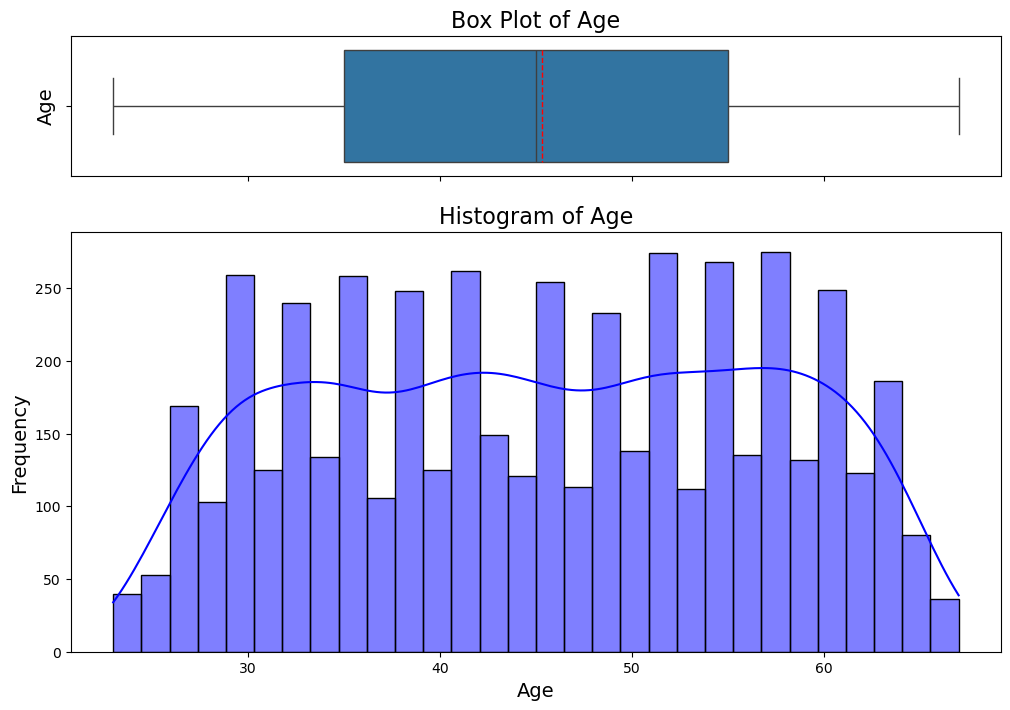

In [35]:
# box plot distribution of features and target variable Personal Loan

def eda_plots(df, target_col):
    """
    Generate box plots for each feature in the DataFrame against the target variable.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    target_col (str): The name of the target column.
    """
    figsize = (12, 8)  # Set the figure size for the plots
    bins = 30  # Number of bins for the histogram
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )

    #box plot
    sns.boxplot(x=target_col, data=df, ax=ax_box2,showmeans=True, meanline=True, meanprops={"color": "red", "linestyle": "--"})
    ax_box2.set_title(f'Box Plot of {target_col}', fontsize=16)
    ax_box2.set_ylabel(target_col, fontsize=14) 
    ax_box2.set_xlabel('')  # No x-label for the box plot

    # histogram 
    sns.histplot(df[target_col], kde=True, ax=ax_hist2, color='blue', bins=bins)
    ax_hist2.set_title(f'Histogram of {target_col}', fontsize=16)
    ax_hist2.set_xlabel(target_col, fontsize=14)
    ax_hist2.set_ylabel('Frequency', fontsize=14)
    
    # for feature in features:
    #     plt.figure(figsize=(10, 6))
    #     sns.boxplot(x=target_col, y=feature, data=df)
    #     plt.title(f'Box Plot of {feature} vs {target_col}')
    #     plt.show()

# column Age
eda_plots(pd_clean, 'Age')
#Observations
# The box plot shows that the majority of customers are between 20 and 60 years old, with a few outliers above 60.
# median age is around 45 years.


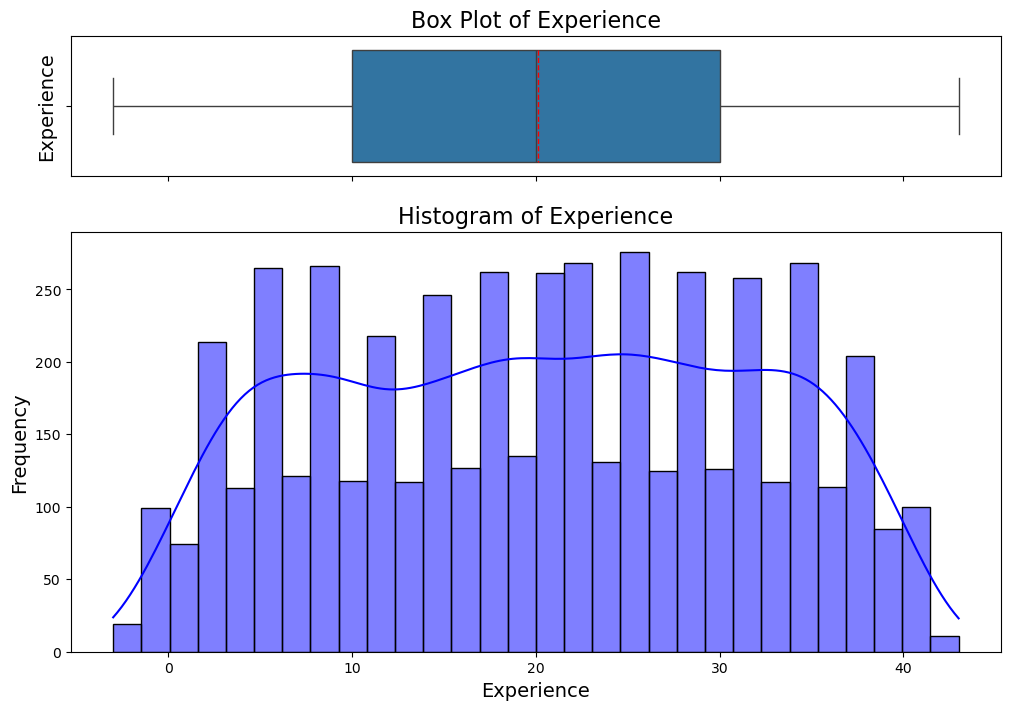

In [ ]:
# column Experience          
eda_plots(pd_clean, 'Experience')
#Observations
# The box plot shows that the majority of customers have between 0 and 40 years of experience, with a few outliers above 40.
# The median experience is around 20 years.


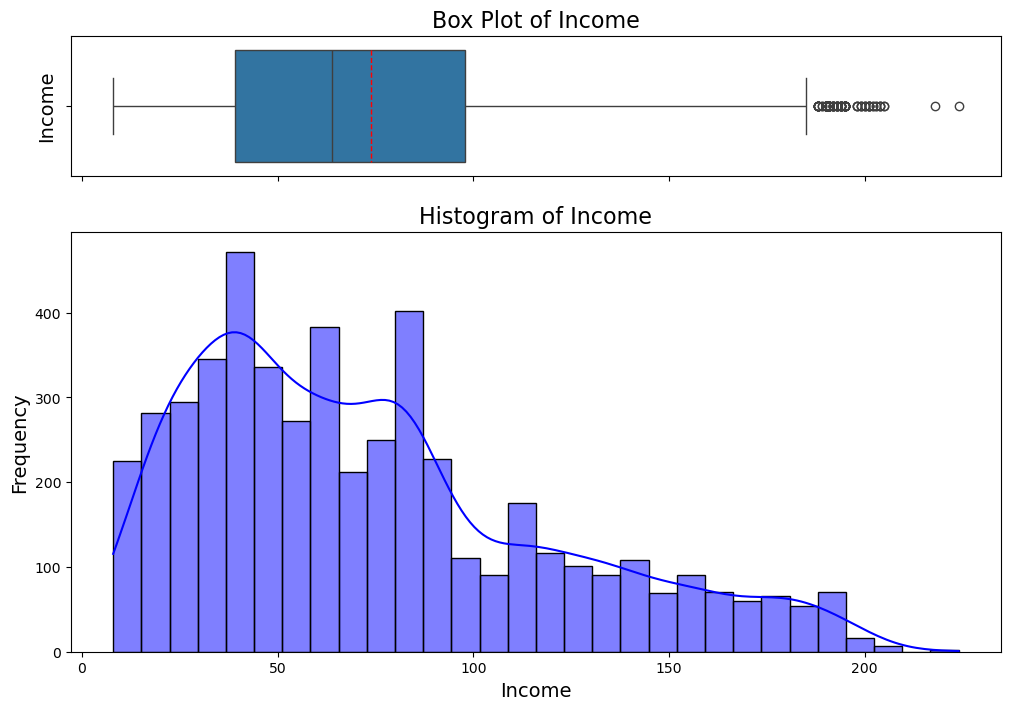

In [37]:
eda_plots(pd_clean, 'Income')
#Observations
# The box plot shows that the majority of customers have an income between 20,000 and 100,000, with a few outliers above 100,000.
# The median income is around 70,000.
# Income data is right skewed, with a few outliers above 100,000.


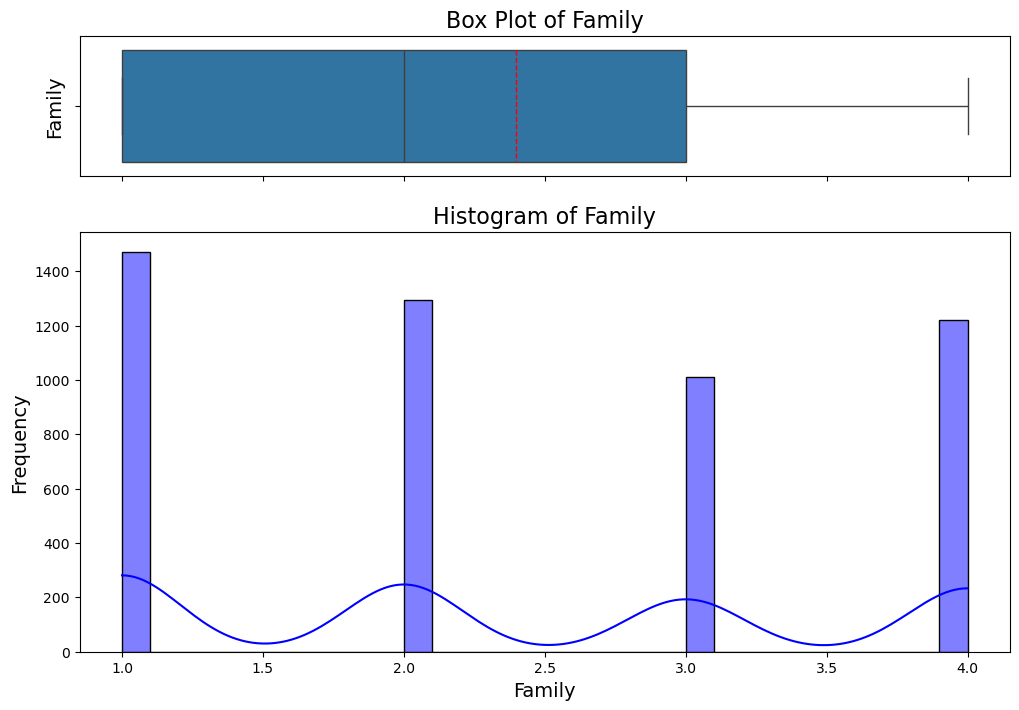

In [38]:
eda_plots(pd_clean, 'Family')
#Observations
# The box plot shows that the majority of customers have a family size of 1 to 4, slightly more customers with family size of 1
#median family size is around 2.

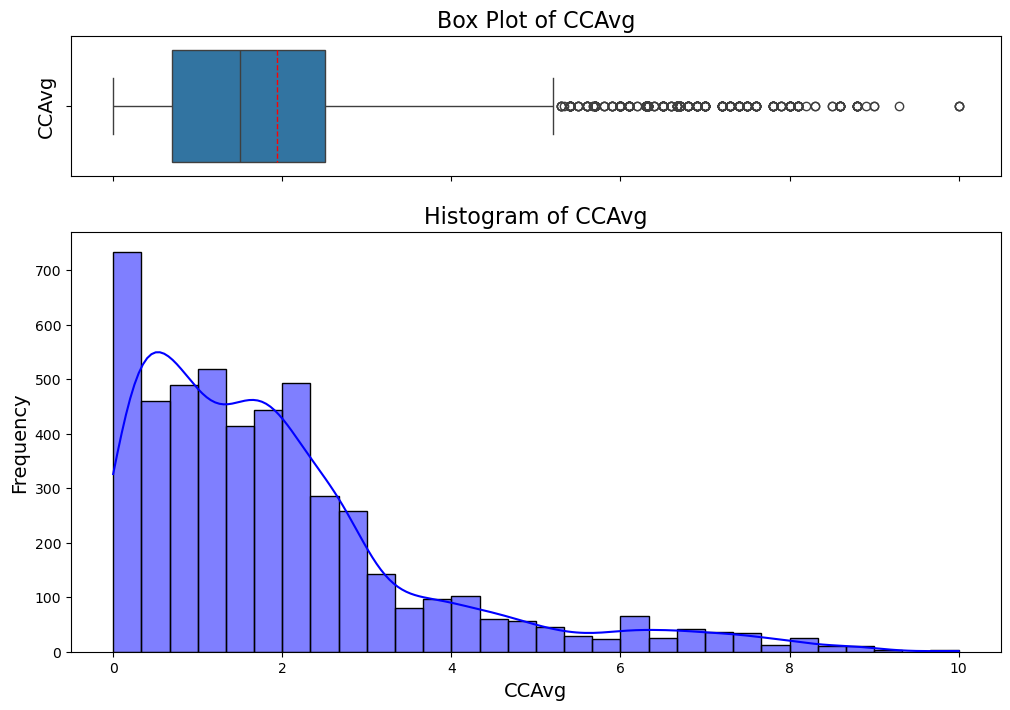

In [39]:
eda_plots(pd_clean, 'CCAvg')
#Observations
# The box plot shows that the majority of customers have a credit card average spending between 0 and 5, with a few outliers above 5.
# The median credit card average spending is around 2.  
# data is right skewed, with a few outliers above 5.

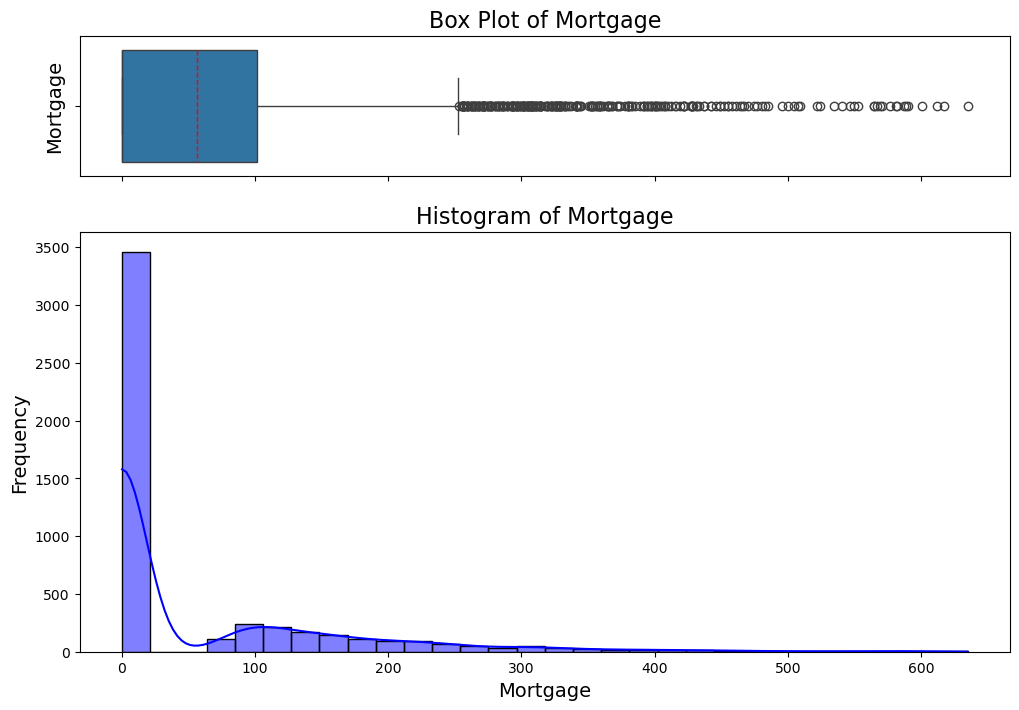

In [ ]:
eda_plots(pd_clean, 'Mortgage')
#observations
# The box plot shows that the majority of customers have a mortgage between 0 and 200,000, with a few outliers above 200,000.
# The median mortgage is around 50,000.
# The data is right skewed, with a few outliers above 200,000.


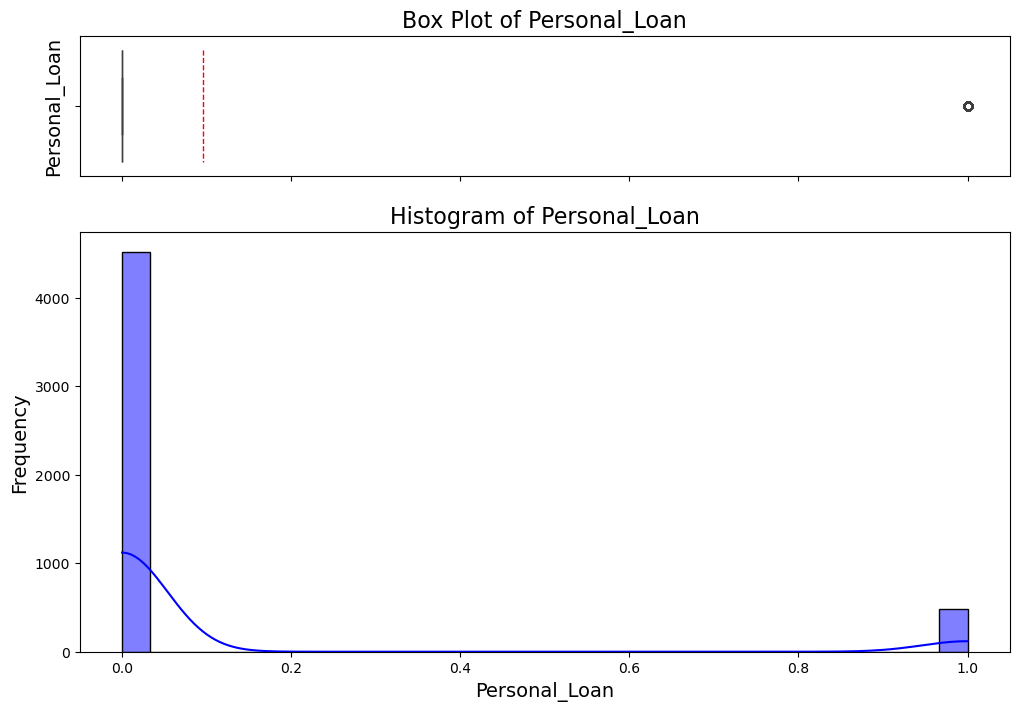

In [ ]:
eda_plots(pd_clean, 'Personal_Loan')
#Observations
# majority of customers do not have a personal loan, with a few customers having a personal loan.

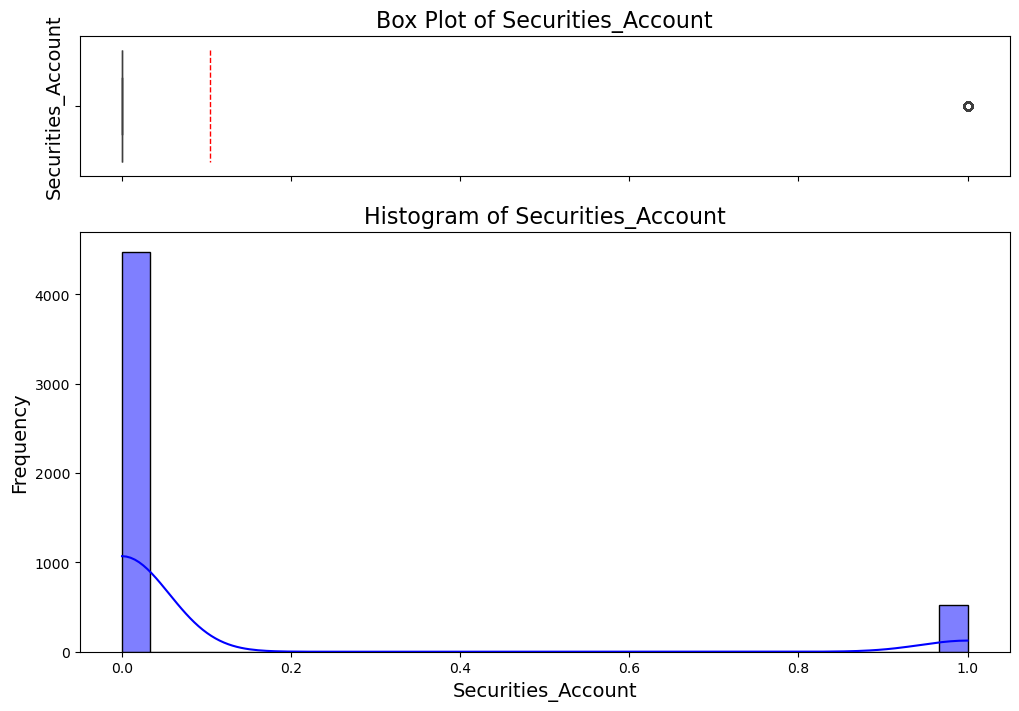

In [ ]:
eda_plots(pd_clean, 'Securities_Account')
#Observations
# The box plot shows that the majority of customers do not have a securities account, with a few customers having a securities account.


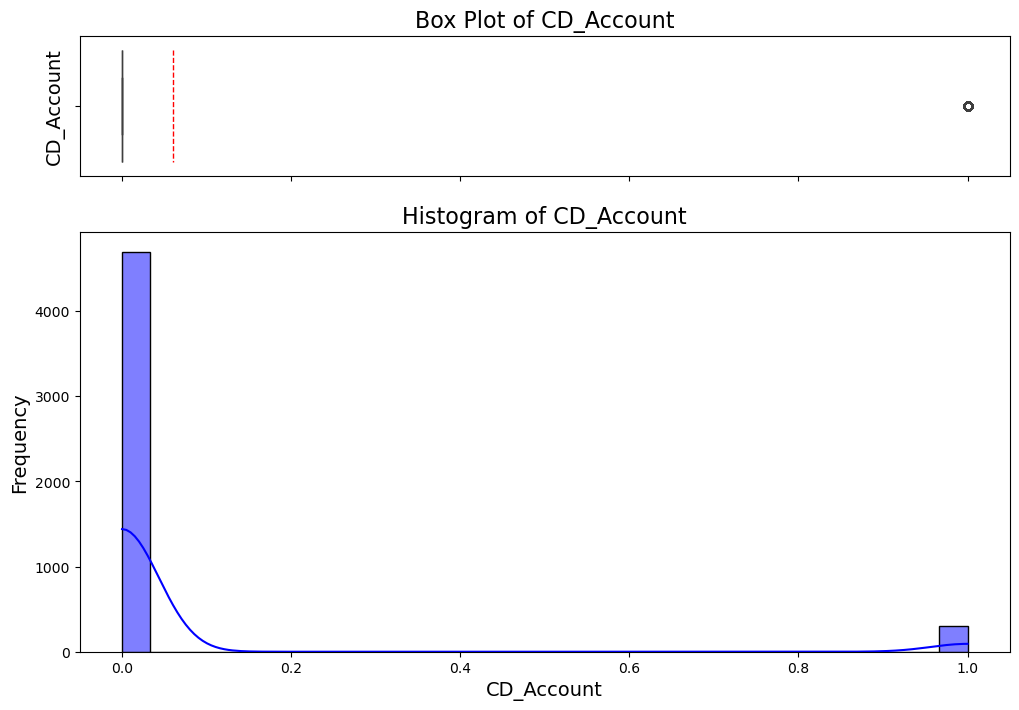

In [ ]:
eda_plots(pd_clean, 'CD_Account')
#Observations
# The box plot shows that the majority of customers do not have a CD account, with a few customers having a CD account.


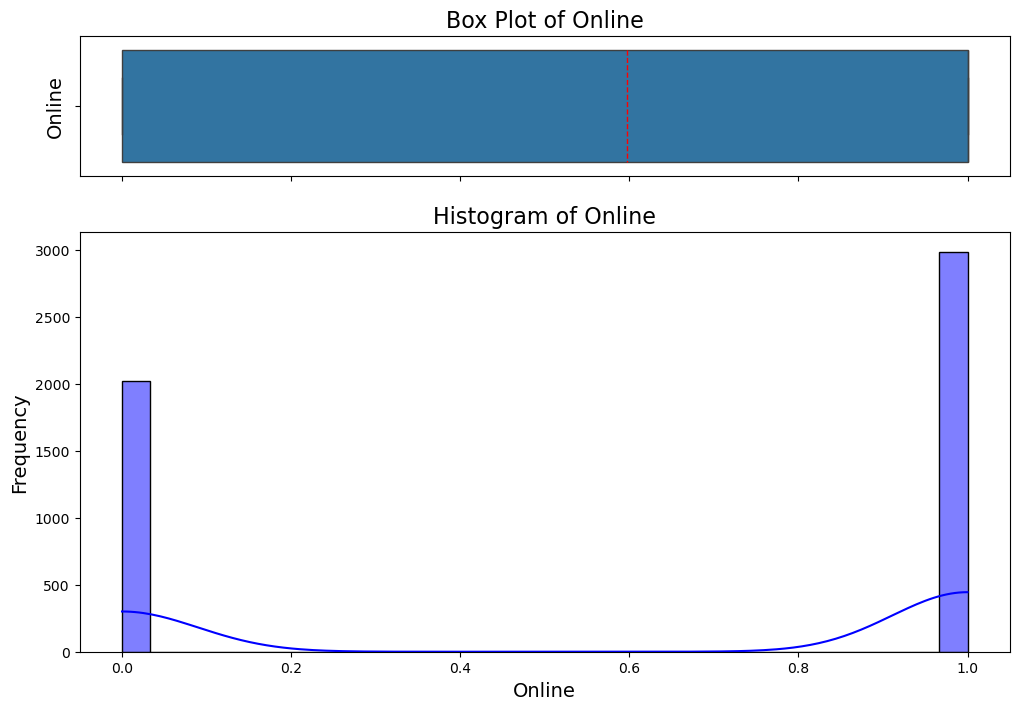

In [ ]:
eda_plots(pd_clean, 'Online')
#Observations
# The box plot shows that the majority of customers do use online banking


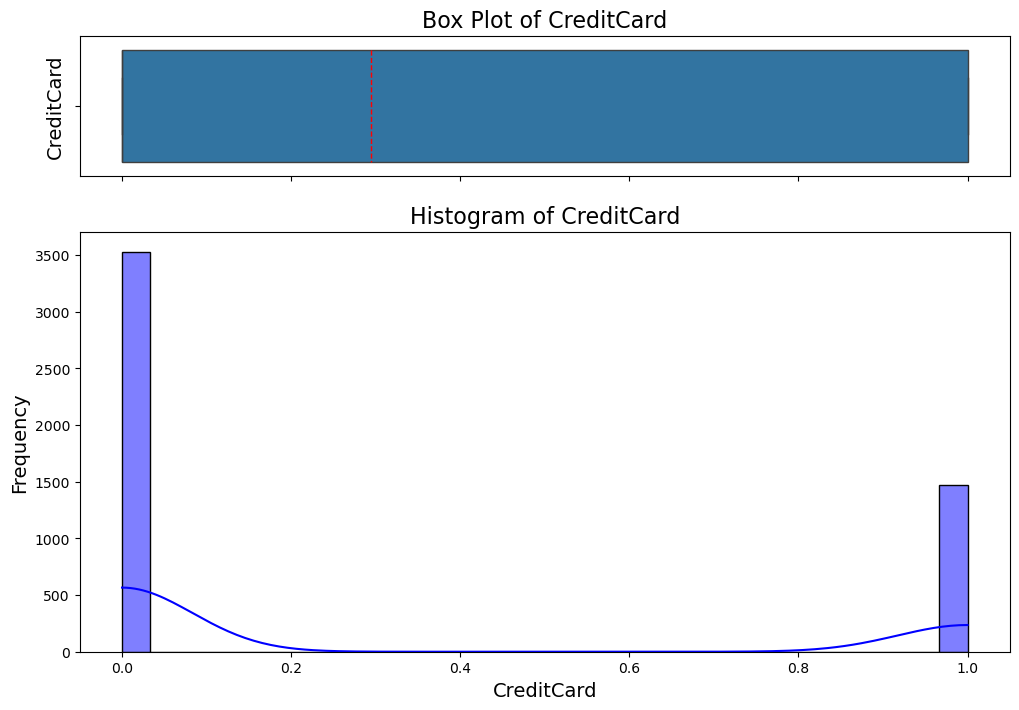

In [ ]:
eda_plots(pd_clean, 'CreditCard')
#Observations
# The box plot shows that the majority of customers do not use a credit card, with a few customers using a credit card.

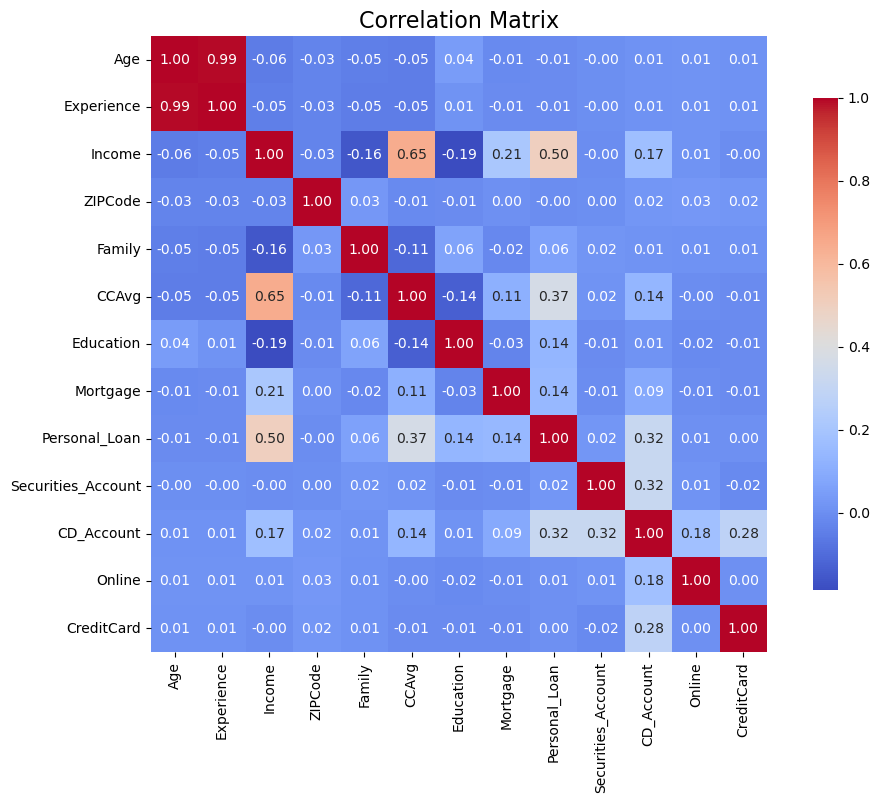

In [ ]:
# correlation between features
def plot_correlation_matrix(df):
    """
    Plot the correlation matrix of the DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    """
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

plot_correlation_matrix(pd_clean)
#Observations
# The dependent variable Personal_Loan has a strong positive correlation with Income, CD_amount, and CCAvg. Income has the highest correlation with Personal_Loan, followed by CCAvg and CD_Account.
# this means that customers with higher income, higher credit card average spending, and higher CD amount are more likely to have a personal loan.


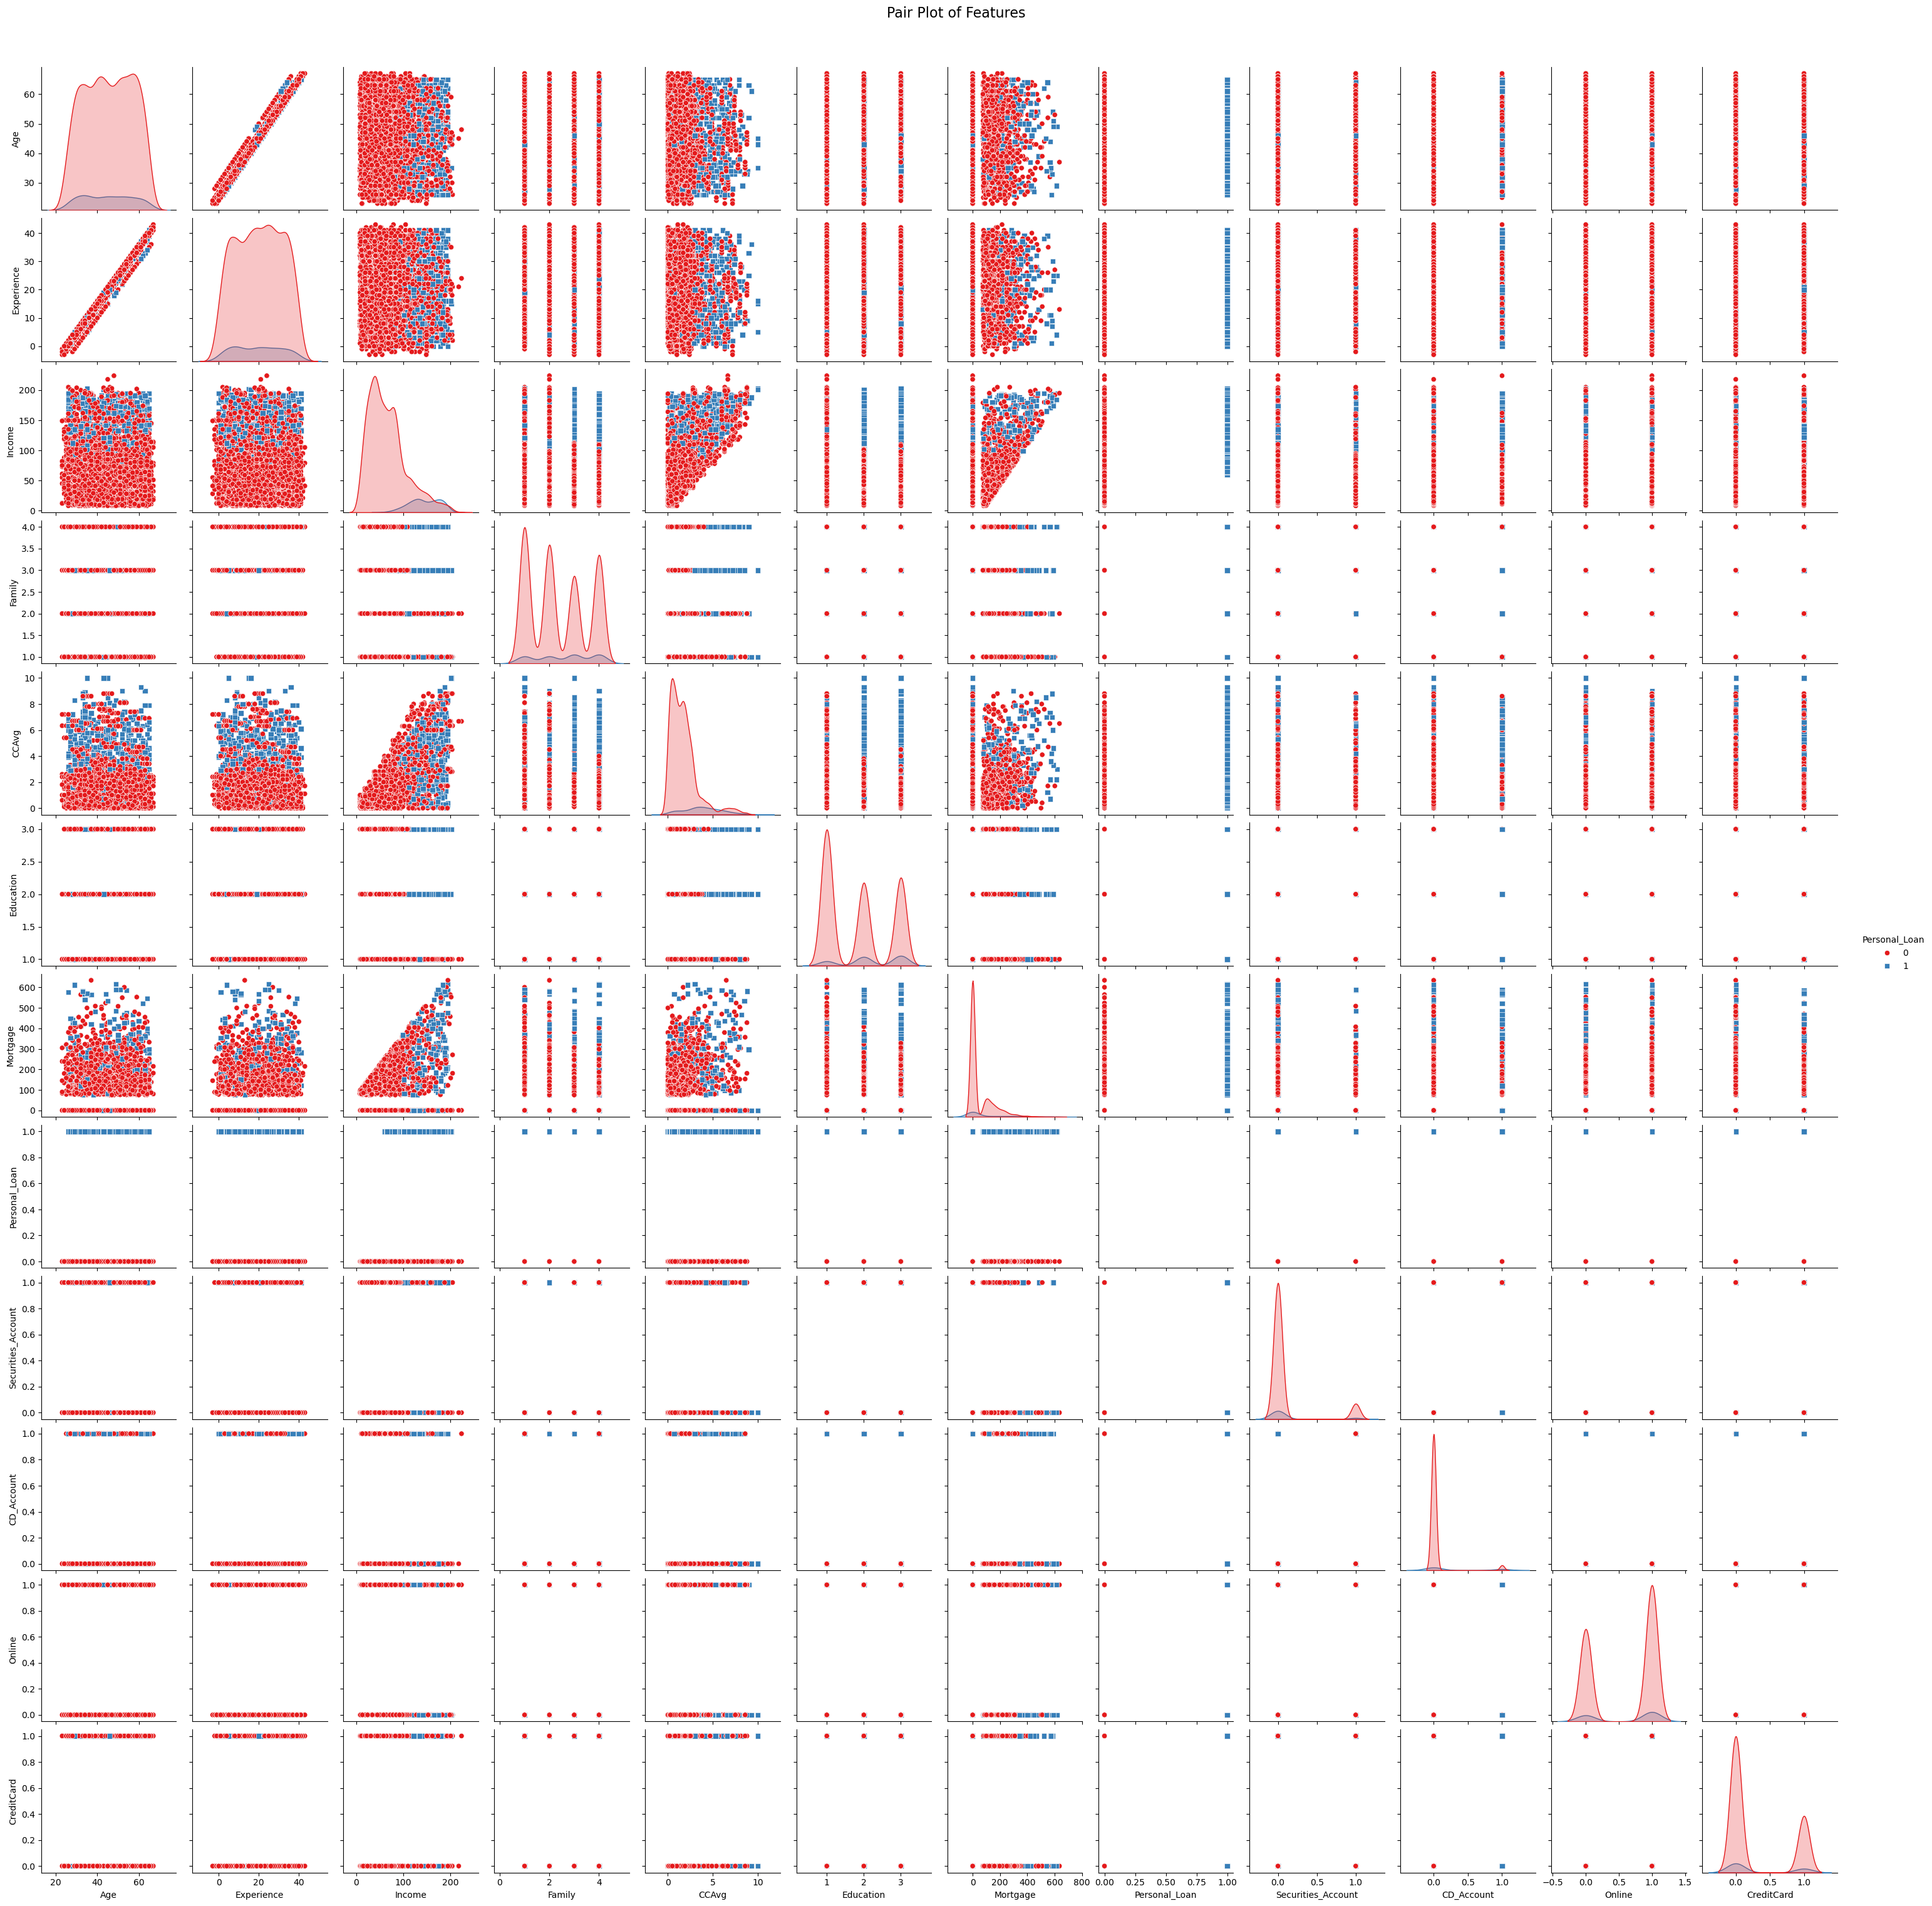

<Figure size 1200x800 with 0 Axes>

In [50]:
#pair plot of features  and target variable as hue
num_features = pd_clean.select_dtypes(include=[np.number]).columns.tolist()

target_col = 'Personal_Loan'
sns.pairplot(pd_clean, hue=target_col, vars= num_features, diag_kind='kde', markers=["o", "s"], palette="Set1")
plt.suptitle('Pair Plot of Features', y=1.02, fontsize=16)
plt.show()
plt.figure(figsize=(12, 8))
plt.tight_layout()




## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

In [ ]:
# No missing values in the dataset, so no need to handle missing values.
# No duplicate rows in the dataset, so no need to handle duplicate rows.
#Feature engineering, data is already clean and ready for analysis.

# Zipcode has some corelation with mortgauge however it is not a good feature to use for prediction as it is not a continuous variable and does not have a strong correlation with the target variable.
# remove Zipcode column
pd_clean = pd_clean.drop(['ZIPCode'], axis=1)   







## Model Building

### Model Evaluation Criterion

*


### Model Building

In [ ]:
#create a new dataframe with the features and target variable
X = pd_clean.drop(['Personal_Loan'], axis=1)  # Features
y = pd_clean['Personal_Loan']  # Target variable 

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # stratify to maintain the proportion of target variable in train and test sets

# No need to encode categorical variables as they are already in numerical format. No use to use "get_dummies" as the categorical variables are already in numerical format 0 or 1

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTree(random_state=42)
# Fit the model on the training data
dt_classifier.fit(X_train, y_train)



Text(0.5, 1.0, 'Decision Tree for Personal Loan Prediction')

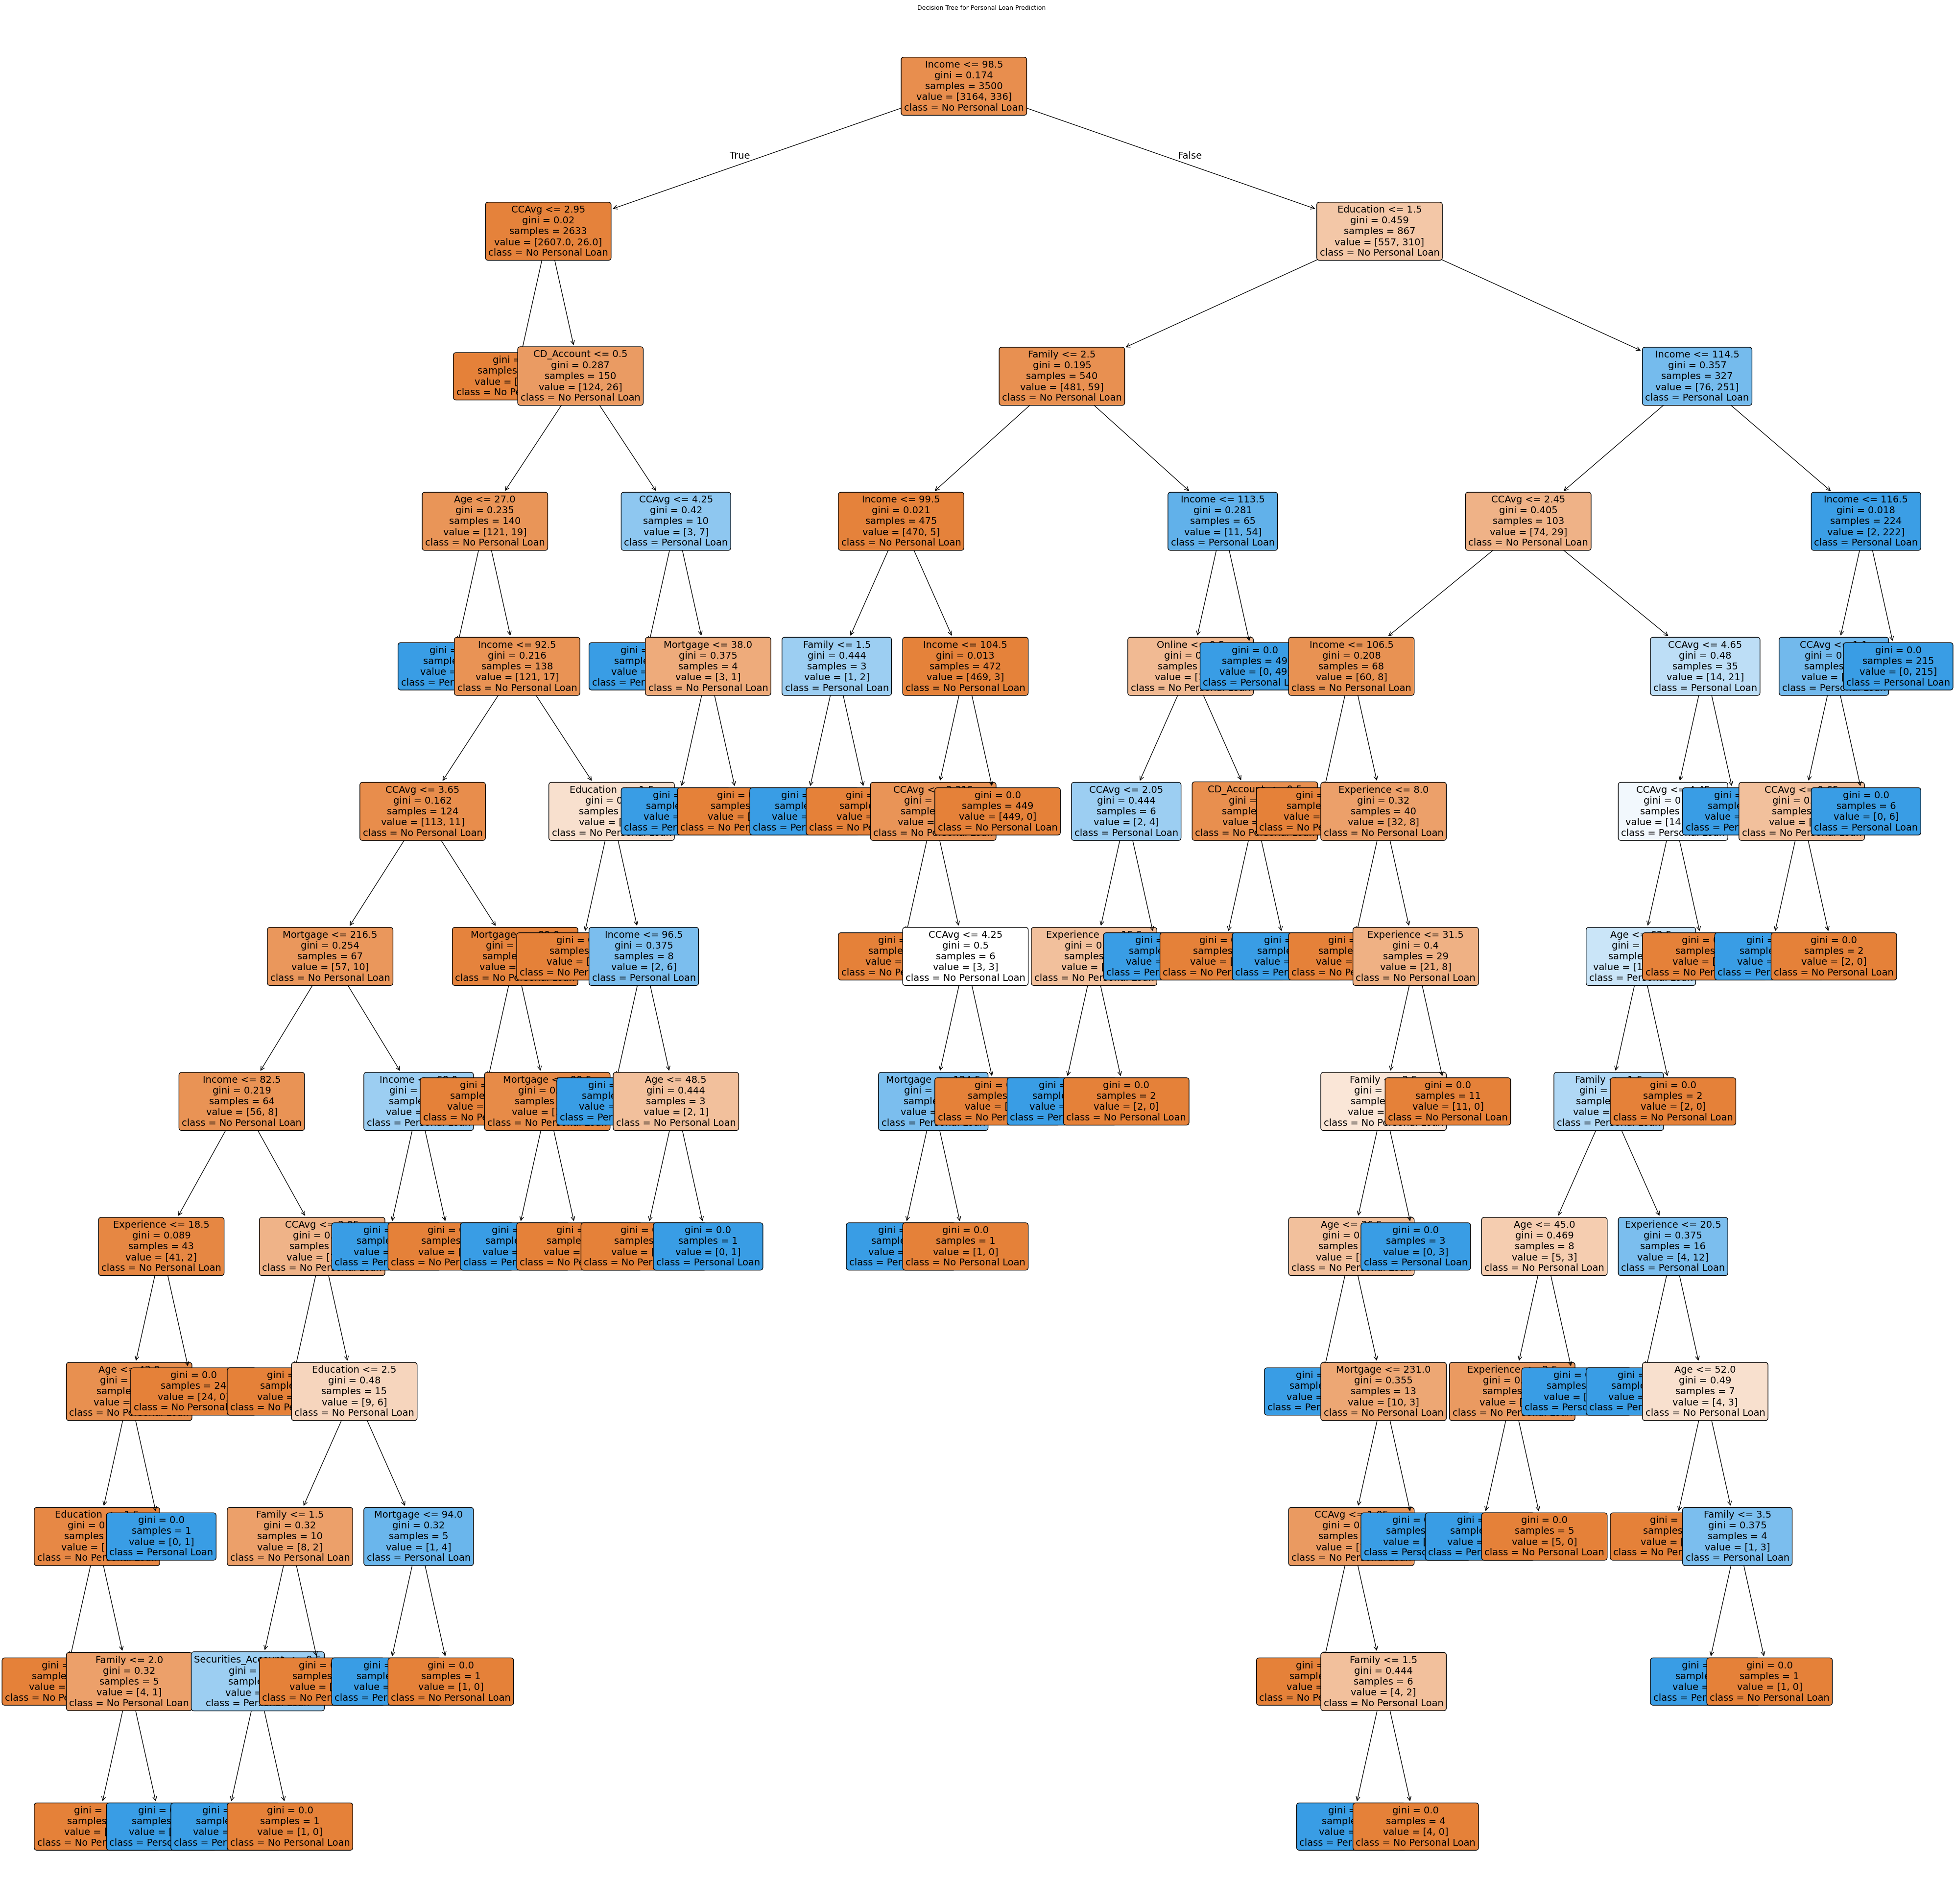

In [73]:
#plot the decision tree
plt.figure(figsize=(50, 50))
sktree.plot_tree(dt_classifier, feature_names=X.columns, class_names=['No Personal Loan', 'Personal Loan'], filled=True, rounded=True,fontsize=14)
#sktree.plot_tree(dt_classifier, feature_names=X.columns, filled=True, rounded=True,fontsize=14)
plt.title('Decision Tree for Personal Loan Prediction', fontsize=9)    

In [ ]:
#tree text
text_representation = sktree.export_text(dt_classifier, feature_names=list(X.columns))
print(text_representation)

In [ ]:
#function to evaluate the model , calculate accuracy, confusion matrix, classification report, f1 score, recall score, and precision score

def evaluate_model(model, predictors, target):
    """
    Evaluate the model's performance using various metrics.
    
    Parameters:
    model: The trained model to evaluate.
    predictors (DataFrame): The features used for prediction. Ex : X_train or X_test 
    target (Series): The true target variable. Ex : y_train or y_test
    Returns:
    0 for simplicity 
    """
    # Make predictions on the test data
    y_pred = model.predict(predictors)
    
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    conf_matrix = confusion_matrix(target, y_pred)
    class_report = classification_report(target, y_pred)
    f1 = f1_score(target, y_pred)
    recall = recall_score(target, y_pred)
    precision = precision_score(target, y_pred)
    
    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")  
    print("Classification Report:\n", class_report) 
    print(f"Recall Score: {recall:.4f}")
    print(f"Precision Score: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if accuracy < 0.5:
        print("The model is not performing well, consider tuning the model or using a different model.")
    elif accuracy == 1:
        print("The model is overfitting, pre-pruning and post pruninig methods will be used to tune the model.")
    elif accuracy >= 0.5 and accuracy < 0.8:
        print("The model is performing well, but there is room for improvement pre and post tuning can be used to im prove model.")
    elif accuracy >= 0.8 and accuracy < 0.9:
        print("The model is performing very well. Consider using post tuning methods to improve the model further.")
    

    #confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Personal Loan', 'Personal Loan'], yticklabels=['No Personal Loan', 'Personal Loan'])
    plt.title('Confusion Matrix', fontsize=16)    

    return 0
    # return {
    #     'accuracy': accuracy,
    #     'confusion_matrix': conf_matrix,
    #     'classification_report': class_report,
    #     'f1_score': f1,
    #     'recall_score': recall,
    #     'precision_score': precision
    # }



Evaluating the model using training data...
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3164
           1       1.00      1.00      1.00       336

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500

Recall Score: 1.0000
Precision Score: 1.0000
F1 Score: 1.0000
The model is overfitting, pre-pruning and post pruninig methods will be used to tune the model.


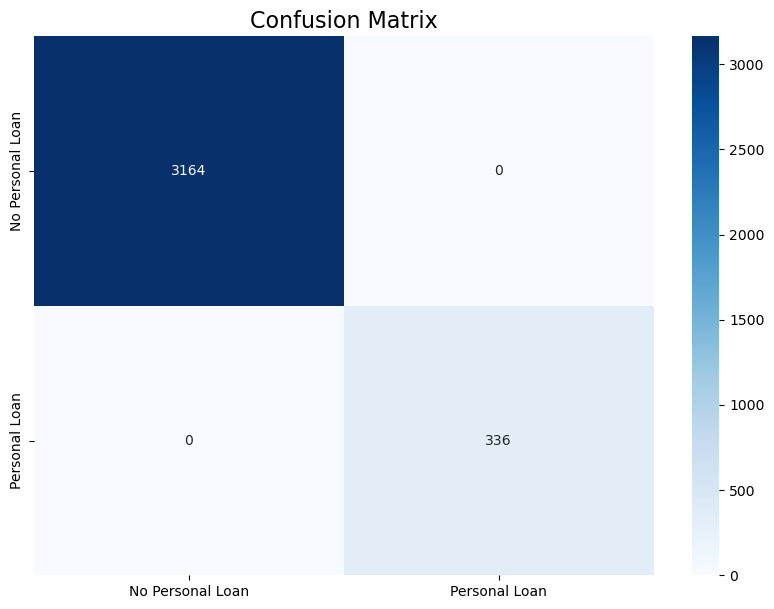

In [88]:
#get original model evaluation using training data
print("Evaluating the model using training data...")
model_eval = evaluate_model(dt_classifier, X_train, y_train)


## Model Performance Improvement

In [85]:
#Pre pruning the model using max_depth, max leaf nodes and  min_samples_split 

max_depth = 7 # Maximum depth of the tree
min_samples_split = [10,20,25,30,35,40,45,50] # Minimum number of samples required to split an internal node
max_leaf_nodes = [10,20,30,40] # Maximum number of leaf nodes in the tree

f1 = 0 
best_f1_diff = 1.0
f1_diff = 0.0
best_depth = 0
best_min_samples = 0
best_leaf_nodes = 0

for depth in range(2, max_depth + 1):
    for leaf_nodes in max_leaf_nodes:
        for min_samples in min_samples_split:
            # Initialize the Decision Tree Classifier with pre-pruning parameters
            dt_pruned = DecisionTree(max_depth=depth, min_samples_split=min_samples, max_leaf_nodes=leaf_nodes, random_state=42, splitter = "best")  # Use balanced class weights to handle class imbalance
            # Fit the model on the training data
            dt_pruned.fit(X_train, y_train)
            y_train_pred_pruned = dt_pruned.predict(X_train)
            y_test_pred_pruned = dt_pruned.predict(X_test)
            # Evaluate the pruned model on the training data
            train_f1 = f1_score(y_train, y_train_pred_pruned)
            test_f1 = f1_score(y_test, y_test_pred_pruned)
            f1_diff = abs(train_f1 - test_f1) # lower the difference between train and test f1 score indicates the model is not overfitting and is generalizing well to unseen data
            if f1_diff < best_f1_diff:
                best_f1_diff = f1_diff
                best_depth = depth
                best_min_samples = min_samples
                best_leaf_nodes = leaf_nodes
                best_model = dt_pruned


# Print the best pre-pruning parameters
print(f"Best Pre-Pruning Parameters: Depth={best_depth}, Min Samples Split={best_min_samples}, Max Leaf Nodes={best_leaf_nodes} , F1 Score Difference={best_f1_diff:.4f}")



Best Pre-Pruning Parameters: Depth=4, Min Samples Split=10, Max Leaf Nodes=20 , F1 Score Difference=0.0001


In [ ]:
#post pruning the model using cost complexity pruning
# Get the cost complexity pruning path
clf = DecisionTree(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[ccp_alphas > 0]  # filter out zero alphas
impurities = path.impurities

# Plot the cost complexity pruning path
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities[:-1], marker='o')
plt.title('Cost Complexity Pruning Path')
plt.xlabel('CCP Alpha')
plt.ylabel('Impurity')
plt.grid()
plt.show()

clfs = []
test_f1_scores = []
train_f1_scores = []
# Train a Decision Tree for each alpha value
for ccp_alpha in ccp_alphas:
    clf = DecisionTree(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    y_train_pred_post_pruned = clf.predict(X_train)
    y_test_pred_post_pruned = clf.predict(X_test)
    train_f1 = f1_score(y_train, y_train_pred_post_pruned)
    test_f1 = f1_score(y_test, y_test_pred_post_pruned)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

# Plot the F1 scores for training and testing sets
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_f1_scores, marker='o', label='Train F1 Score')
plt.plot(ccp_alphas, test_f1_scores, marker='o', label='Test F1 Score')
plt.title('F1 Scores vs. CCP Alpha')
plt.xlabel('CCP Alpha')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()
# Find the best alpha value based on the maximum test F1 score
best_alpha_index = np.argmax(test_f1_scores)
best_alpha = ccp_alphas[best_alpha_index]
print(f"Best CCP Alpha: {best_alpha}")


## Model Performance Comparison and Final Model Selection

In [109]:
def evaluate_model_no_print(orig_model,pre_model,post_model, predictors, target, type = "test"):
    """
    Evaluate the model's performance using various metrics.
    
    Parameters:
    model: The trained model to evaluate.
    predictors (DataFrame): The features used for prediction. Ex : X_train or X_test 
    target (Series): The true target variable. Ex : y_train or y_test
    Returns:
    dict: A dictionary containing accuracy, f1 score, recall score, and precision score.
    """
    # Make predictions on the test data
    y_orig_pred = orig_model.predict(predictors)
    y_pre_pred = pre_model.predict(predictors)
    y_post_pred = post_model.predict(predictors)

    # Calculate accuracy
    orig_model_accuracy = accuracy_score(target, y_orig_pred)
    pre_model_accuracy = accuracy_score(target, y_pre_pred)
    post_model_accuracy = accuracy_score(target, y_post_pred)
    # Calculate f1 score
    orig_model_f1 = f1_score(target, y_orig_pred)
    pre_model_f1 = f1_score(target, y_pre_pred)
    post_model_f1 = f1_score(target, y_post_pred)
    # Calculate recall score
    orig_model_recall = recall_score(target, y_orig_pred)
    pre_model_recall = recall_score(target, y_pre_pred)
    post_model_recall = recall_score(target, y_post_pred)
    # Calculate precision score
    orig_model_precision = precision_score(target, y_orig_pred)
    pre_model_precision = precision_score(target, y_pre_pred)
    post_model_precision = precision_score(target, y_post_pred)

    # print f1 score of the original model, pre pruned model and post pruned model
    print(f"F1 score for the {type} data:")
    print(f"F1 Score - Original: {orig_model_f1}, Pre-pruned: {pre_model_f1}, Post-pruned: {post_model_f1}")

    # if orig_model_f1 > pre_model_f1 and orig_model_f1 > post_model_f1:
    #     print(f"The original model performed well for the {type} data and has the best F1 score: {orig_model_f1}, compared to Pre {pre_model_f1} and Post-pruned {post_model_f1} model.")
    # elif pre_model_f1 > orig_model_f1 and pre_model_f1 > post_model_f1:
    #     print(f"The pre-pruned model performed well for the {type} data and has the best F1 score: {pre_model_f1}, compared to Original {orig_model_f1} and Post-pruned {post_model_f1}  model.")
    # elif post_model_f1 > orig_model_f1 and post_model_f1 > pre_model_f1:
    #     print(f"The post-pruned model performed well for the {type} data and has the best F1 score: {post_model_f1}, compared to Original {orig_model_f1} and Pre-pruned {pre_model_f1}  model.")
    # else:
    #     print("All models have the same F1 score.")

    return {
        'orig_model_f1': orig_model_f1,
        'pre_pruned_model_f1': pre_model_f1,
        'post_pruned_model_f1': post_model_f1
    }


In [112]:
test_eval = evaluate_model_no_print(dt_classifier, best_model, clfs[best_alpha_index], X_test, y_test,"Test")

                              

F1 score for the Test data:
F1 Score - Original: 0.9003436426116839, Pre-pruned: 0.9220338983050848, Post-pruned: 0.9411764705882353


In [113]:
train_eval = evaluate_model_no_print(dt_classifier, best_model, clfs[best_alpha_index], X_train, y_train,"Train")

F1 score for the Train data:
F1 Score - Original: 1.0, Pre-pruned: 0.9221374045801527, Post-pruned: 0.9143730886850153


[Text(0.3958333333333333, 0.9, 'Income <= 98.5\ngini = 0.174\nsamples = 3500\nvalue = [3164, 336]\nclass = No Personal Loan'),
 Text(0.125, 0.7, 'CCAvg <= 2.95\ngini = 0.02\nsamples = 2633\nvalue = [2607.0, 26.0]\nclass = No Personal Loan'),
 Text(0.26041666666666663, 0.8, 'True  '),
 Text(0.08333333333333333, 0.5, 'gini = 0.0\nsamples = 2483\nvalue = [2483, 0]\nclass = No Personal Loan'),
 Text(0.16666666666666666, 0.5, 'CD_Account <= 0.5\ngini = 0.287\nsamples = 150\nvalue = [124, 26]\nclass = No Personal Loan'),
 Text(0.08333333333333333, 0.3, 'Age <= 27.0\ngini = 0.235\nsamples = 140\nvalue = [121, 19]\nclass = No Personal Loan'),
 Text(0.041666666666666664, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Personal Loan'),
 Text(0.125, 0.1, 'gini = 0.216\nsamples = 138\nvalue = [121, 17]\nclass = No Personal Loan'),
 Text(0.25, 0.3, 'CCAvg <= 4.25\ngini = 0.42\nsamples = 10\nvalue = [3, 7]\nclass = Personal Loan'),
 Text(0.20833333333333334, 0.1, 'gini = 0.0\nsamples = 6\nval

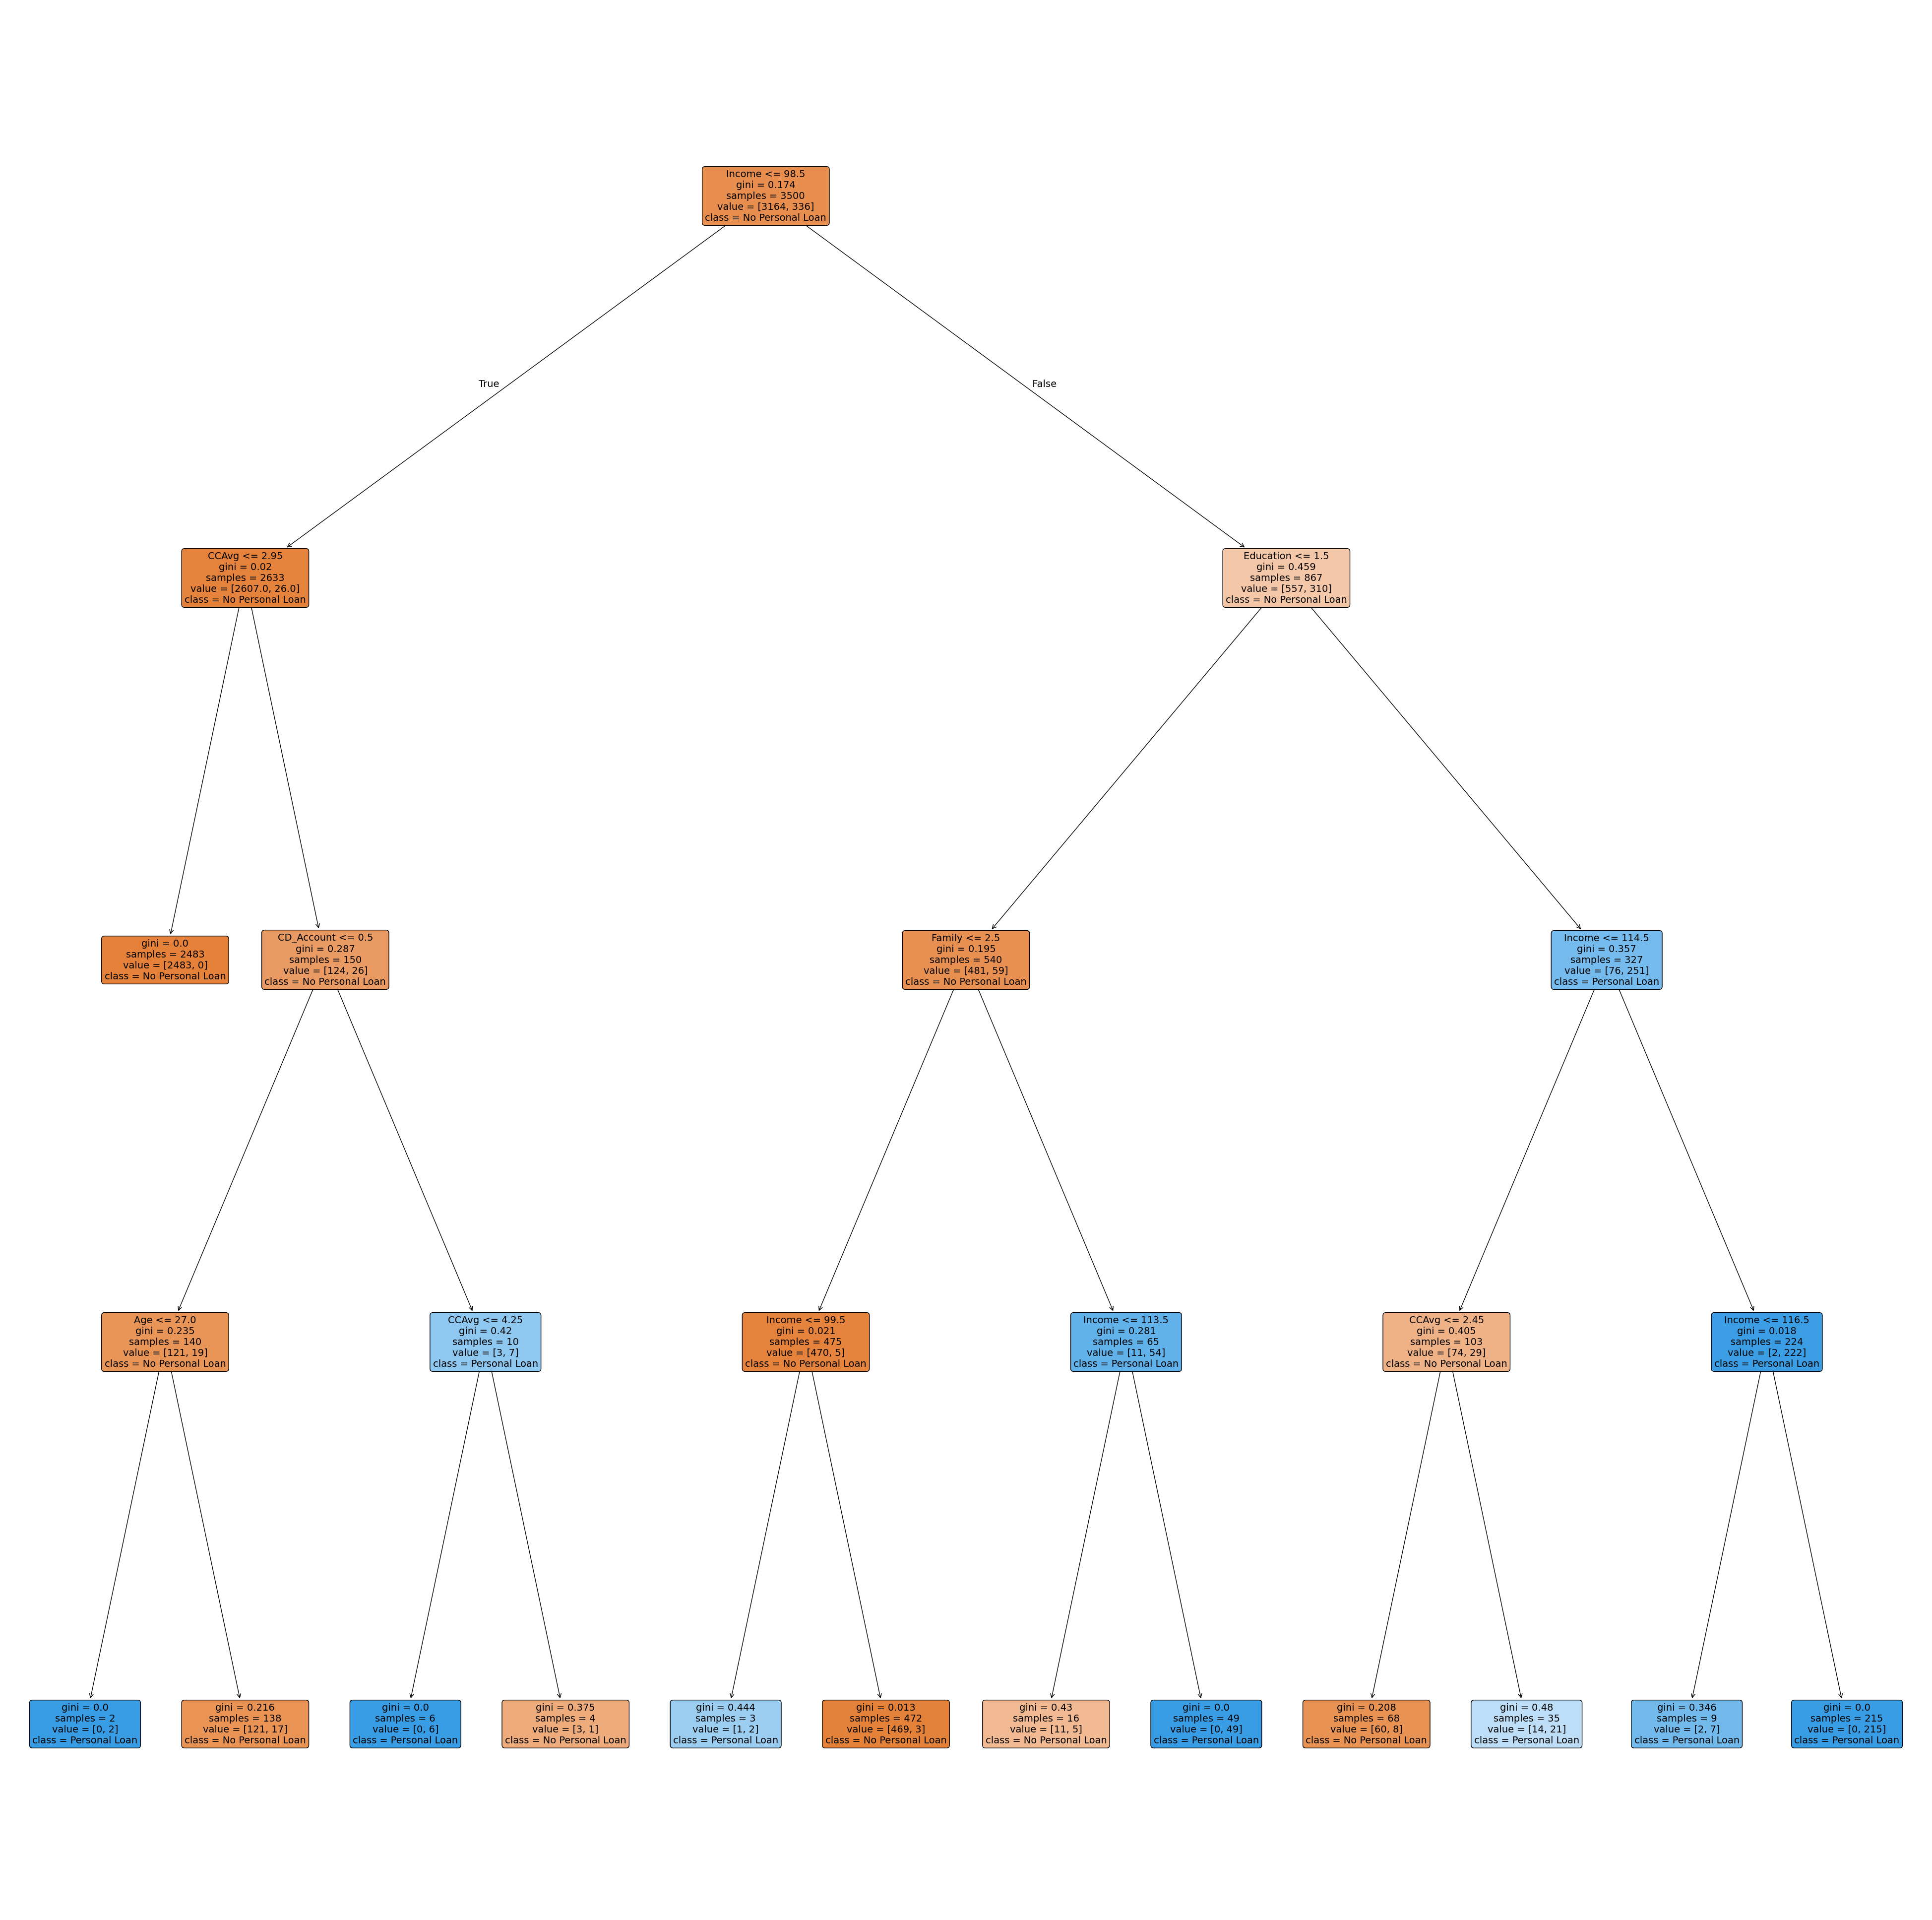

In [122]:
#print pre-pruned Tree
plt.figure(figsize=(50, 50))
sktree.plot_tree(best_model, feature_names=X.columns, class_names=['No Personal Loan', 'Personal Loan'], filled=True, rounded=True, fontsize=14)


[Text(0.4, 0.9, 'Income <= 98.5\ngini = 0.174\nsamples = 3500\nvalue = [3164, 336]\nclass = No Personal Loan'),
 Text(0.13333333333333333, 0.7, 'CCAvg <= 2.95\ngini = 0.02\nsamples = 2633\nvalue = [2607.0, 26.0]\nclass = No Personal Loan'),
 Text(0.26666666666666666, 0.8, 'True  '),
 Text(0.06666666666666667, 0.5, 'gini = 0.0\nsamples = 2483\nvalue = [2483, 0]\nclass = No Personal Loan'),
 Text(0.2, 0.5, 'CD_Account <= 0.5\ngini = 0.287\nsamples = 150\nvalue = [124, 26]\nclass = No Personal Loan'),
 Text(0.13333333333333333, 0.3, 'gini = 0.235\nsamples = 140\nvalue = [121, 19]\nclass = No Personal Loan'),
 Text(0.26666666666666666, 0.3, 'gini = 0.42\nsamples = 10\nvalue = [3, 7]\nclass = Personal Loan'),
 Text(0.6666666666666666, 0.7, 'Education <= 1.5\ngini = 0.459\nsamples = 867\nvalue = [557, 310]\nclass = No Personal Loan'),
 Text(0.5333333333333333, 0.8, '  False'),
 Text(0.4666666666666667, 0.5, 'Family <= 2.5\ngini = 0.195\nsamples = 540\nvalue = [481, 59]\nclass = No Personal L

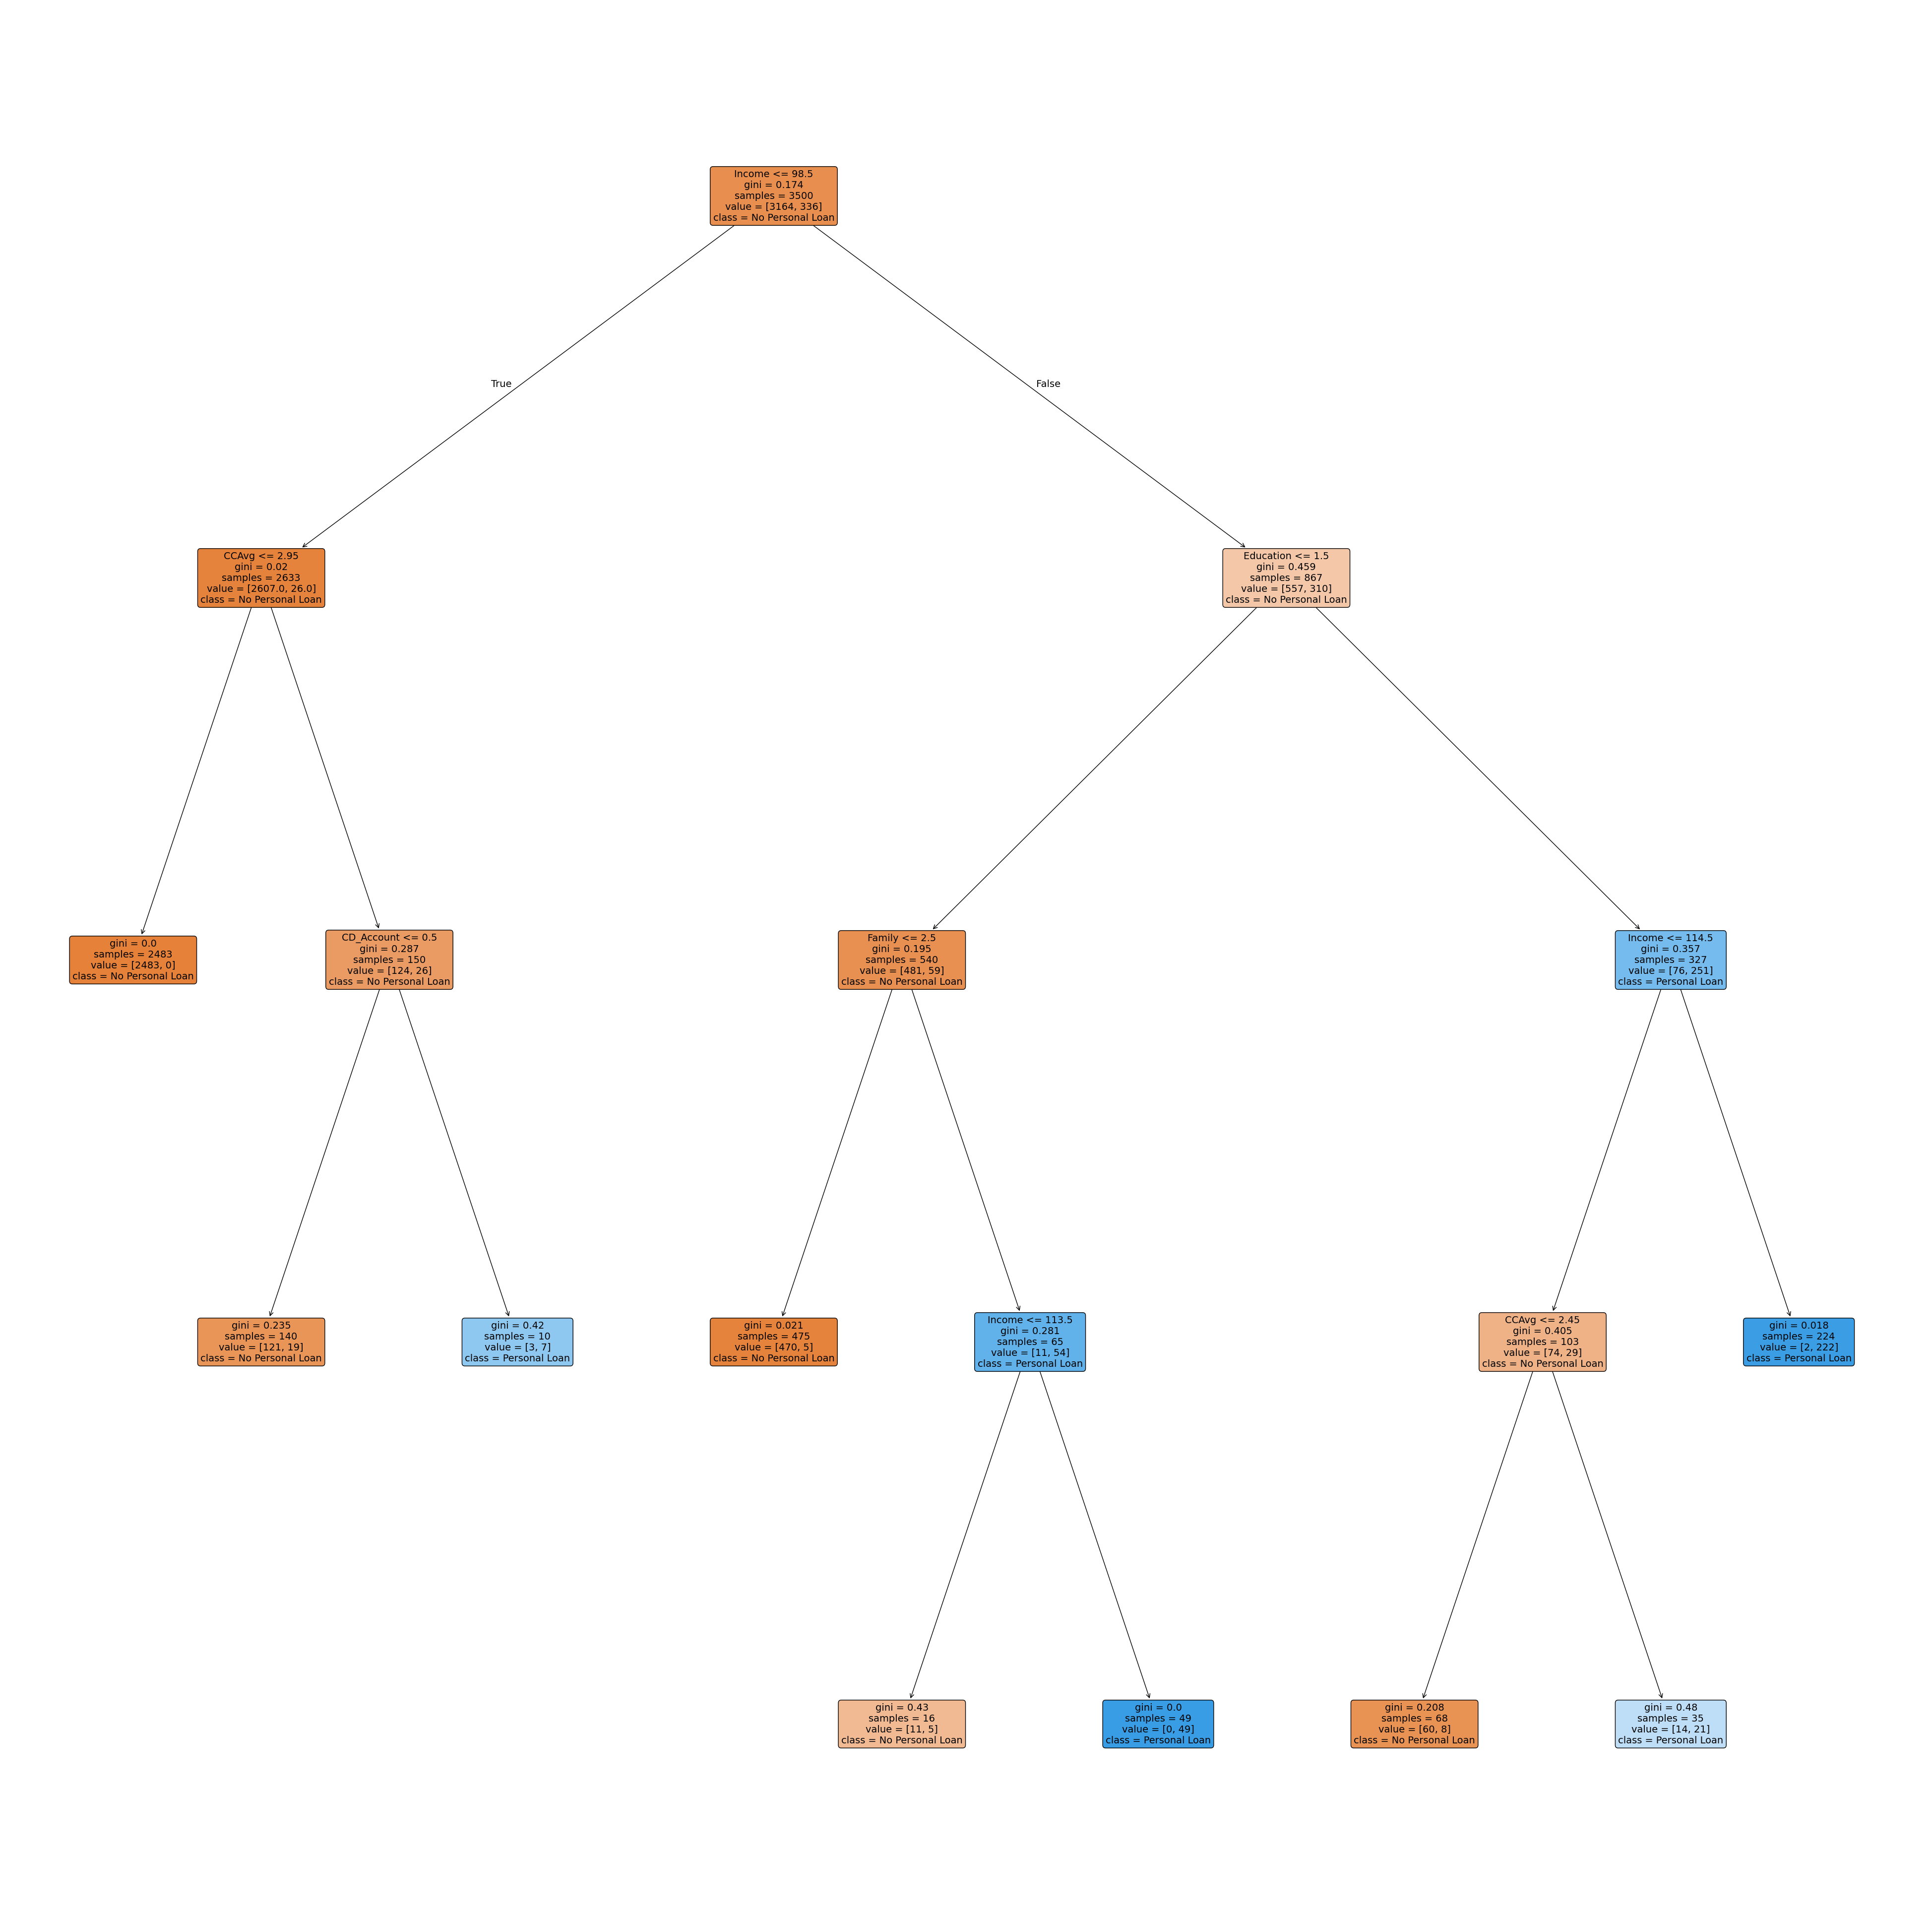

In [123]:
#print  post-pruned Tree
plt.figure(figsize=(50, 50))  
sktree.plot_tree(clfs[best_alpha_index], feature_names=X.columns, class_names=['No Personal Loan', 'Personal Loan'], filled=True, rounded=True, fontsize=14)

In [128]:
print(f"Original Model without pre and post pruning is NOT recomended.\nThe model is overfitting (F1 score {train_eval['orig_model_f1']:.4f}) on the training data and did not perform well on Test data (F1 score {test_eval['orig_model_f1']:.4f}).")
print("\n")
print("\n")
print(f"The Post-pruned model is NOT recomended.\nThe model performed slightly worse on the Test data.\nModel details: ccp_alpha={best_alpha}, F1 score of {train_eval['post_pruned_model_f1']:.4f} on the training data and {test_eval['post_pruned_model_f1']:.4f} on the test data.")
print("\n")
print("\n")
print(f"The Pre-pruned model is RECOMENDED.\nThe model generalizes well with Test and Train data.The model also uses more features than the post-pruned model in decision making.\nModel Details: max_depth={best_depth}, min_samples_split={best_min_samples}, max_leaf_nodes={best_leaf_nodes}, F1 score of {train_eval['pre_pruned_model_f1']:.4f} on the training data and {test_eval['pre_pruned_model_f1']:.4f} on the test data.")

Original Model without pre and post pruning is NOT recomended.
The model is overfitting (F1 score 1.0000) on the training data and did not perform well on Test data (F1 score 0.9003).




The Post-pruned model is NOT recomended.
The model performed slightly worse on the Test data.
Model details: ccp_alpha=0.0009328066710555192, F1 score of 0.9144 on the training data and 0.9412 on the test data.




The Pre-pruned model is RECOMENDED.
The model generalizes well with Test and Train data.The model also uses more features than the post-pruned model in decision making.
Model Details: max_depth=4, min_samples_split=10, max_leaf_nodes=20, F1 score of 0.9221 on the training data and 0.9220 on the test data.


## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?

In [ ]:
# business recommendations
print ("Recommendations\n")
print ("The pre-pruned model is recommended for predicting wether a liability customer is likely to purchase personal loans.\nThese customer attributes are significant\n  Income\n  Education\n  CCAvg\n  CDAccount\n  Family\n  Age\n " )
print ("These segment of customers can be targetted for personal loan offers.\n Income above 98k\n CCAvg above 2.5\n Family size of 2 or more\n")


Recommendations

The pre-pruned model is recommended for predicting wether a liability customer is likely to purchase personal loans.
These customer attributes are significant
  Income
  Education
  CCAvg
  CDAccount
  Family
  Age
 
These segment of customers can be targetted for personal loan offers.
 Income above 98k
 CCAvg above 2.5
 Family size of 2 or more

